# Working with Neural DEs and PDEs 

The Neural DE approach is also very suitable for high-dimensional dynamical systems like PDEs. 

If you want to work on a PDE, we provide you here with some code that gets you starting much quicker. We'll solve the PDEs with a finite difference approach. This notebook is not meant as an introduction to these methods [(here is one)](https://github.com/TUM-PIK-ESM/TUM-Dynamics-Lecture/blob/main/lectures/lecture-9/lecture9-fd.ipynb), but the time in the workshop might be a bit too short if you are not already familar with these methods. 

## Example of Solving a PDE in Julia 

As an example we will solve the Kuramoto-Sivashinsky equation 

$$\frac{\partial u}{\partial t} = -\frac{\partial^4 u}{\partial x^4} - \frac{\partial^2 u}{\partial x^2} + u\cdot\frac{\partial u}{\partial x}$$  

with a finite difference approach. 

For this we first define Julia structs that will save the finite difference matrices that discretize the derivative operators. We solve the PDE on periodic boundary conditions: 

In [1]:
pwd()

"/Users/max/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/notebook-assets"

In [2]:
import Pkg 
Pkg.activate("..") # we want to use the same environment as in the main jupyter notebook.
# depending on your working directory you might need to use a different path here

Pkg.add("LinearAlgebra")
Pkg.add("SparseArrays")
Pkg.add("Distributions")

  Activating project at `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project.toml`
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project.toml`
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project.toml`
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Manifest.toml`


In [3]:
using LinearAlgebra, SparseArrays, Distributions, DifferentialEquations, Plots, Flux

"""
    ∂x_PBC(n::Integer, dx::T)

2nd order central finite difference matrix for 1d domains with periodic boundary conditions
"""
function ∂x_PBC(n::Integer, dx::T) where T
    ∂x = (diagm(1=>ones(T, n-1)) + diagm(-1=>-1*ones(T, n-1)))
    ∂x[1,end] = T(-1)
    ∂x[end,1] = T(1)
    ∂x ./= (2*dx)
    return sparse(∂x)
end

"""
    ∂x²_PBC(n::Integer, dx::T)

2nd order central finite difference matrix of the second derivative for 1d domains with periodic boundary conditions
"""
function ∂x²_PBC(n::Integer, dx::T) where T
    ∂x² = diagm(0=>-2*ones(T, n)) + diagm(-1=>ones(T, n-1)) + diagm(1=>ones(T, n-1))
    ∂x²[1,end] = 1
    ∂x²[end,1] = 1
    ∂x² ./= (dx)^2
    return sparse(∂x²)
end

"""
    ∂x⁴_PBC(n::Integer, dx::T)

4th derivative finite difference matrix with periodic boundary conditions
"""
function ∂x⁴_PBC(n::Integer, dx::T) where T
    ∂x² = ∂x²_PBC(n, dx)
    return sparse(∂x² * ∂x²)
end


∂x⁴_PBC

The functions construct the finite difference matrices that we need to discretize the PDE.

* For the discritization itself we use $n=128$ grid points and a domain size of $L=36$. As mentioned periodic boundary conditions are applied. 

* We use random initial conditions 

In [4]:
n = 128 # number of grid points
L = 36 # domain size 

# generate KS data and construct the FD Operators
∂x = ∂x_PBC(n, Float32(L/(n-1)))
∂x² = ∂x²_PBC(n, Float32(L/(n-1)))
∂x⁴ = ∂x⁴_PBC(n, Float32(L/(n-1)))

# initial condition
u0 = 0.01f0*(rand(Float32, n) .- 0.5f0)

# PDE rhs 
function ks!(du,u,p,t)
    du .= -∂x⁴*u - ∂x²*u - u.*(∂x*u)
end

# time interval for the integration 
t_transient = 200.
N_t = 1000
dt = 0.1
tspan = (0f0, Float32(t_transient + N_t * dt))

# we define the PDE 
prob = ODEProblem(ks!, u0, tspan)

# and solve it
sol = solve(prob, Tsit5(), saveat=Float32.(t_transient:dt:t_transient + N_t * dt))

retcode: Success
Interpolation: 1st order linear
t: 1001-element Vector{Float32}:
 200.0
 200.1
 200.2
 200.3
 200.4
 200.5
 200.6
 200.7
 200.8
 200.9
 201.0
 201.1
 201.2
   ⋮
 298.9
 299.0
 299.1
 299.2
 299.3
 299.4
 299.5
 299.6
 299.7
 299.8
 299.9
 300.0
u: 1001-element Vector{Vector{Float32}}:
 [1.5665308, 1.8345834, 2.012059, 2.055267, 1.9274777, 1.6095409, 1.1094764, 0.46755648, -0.24755408, -0.95144904  …  -0.03043177, -0.11342724, -0.14657219, -0.12052901, -0.030094445, 0.1257121, 0.3432288, 0.6139195, 0.9234025, 1.2505867]
 [1.5568504, 1.8201876, 1.9913845, 2.0275564, 1.8929219, 1.5698913, 1.0677544, 0.42790827, -0.2809506, -0.9750623  …  -0.039725672, -0.12397308, -0.1574623, -0.13081303, -0.039204095, 0.1181649, 0.33708295, 0.60873127, 0.91814, 1.2439728]
 [1.5475069, 1.805827, 1.9704506, 1.9993228, 1.8576738, 1.5294917, 1.0253613, 0.38778076, -0.3145599, -0.99860454  …  -0.048430204, -0.13377109, -0.16745809, -0.14008896, -0.047229316, 0.11172272, 0.33201063, 0.6045181,

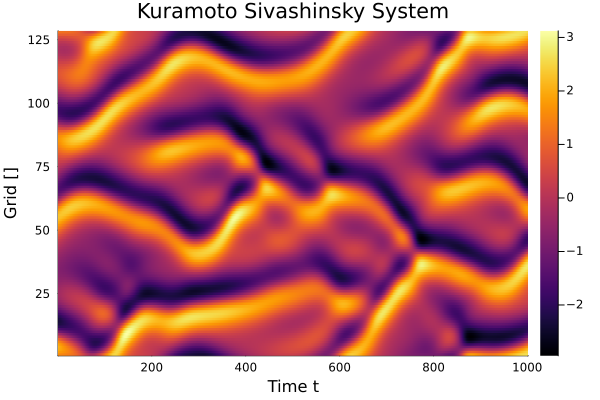

In [5]:
heatmap(Array(sol), xlabel="Time t", ylabel="Grid []", title="Kuramoto Sivashinsky System")

## Neural DEs for PDEs 

We can also integrate the finite difference matrices in our ANN. For this we also introduce another kind of layer, the *Nabla layer* that is a parameterized application of a finite difference matrix. So the neural network can also learn to take a derivative or not. The parameter is penalized in the loss function so that it will likely be either $0$ or $1$:

$$\nabla(x;w) = w \cdot (\partial x)\times x + (1 - w) x$$

* With this, we can also see how to define custom layers in `Flux.jl`
    * Custom layers are `structs`
    * They are overloaded so that an instance of the `struct` can be called directly (`(nab::NablaSkipConnection{F,S})(input) where {F,S}`)
    * To make them usuable with `Flux`, one needs to call `Flux.@functor` and if not all fields of the struct are supposed to be trainable, declare which ones are with `Flux.trainable(nab::NablaSkipConnection) = (w = nab.w,)`

In [6]:
"""
  NablaSkipConnection

With the input ``x``, passes ``w * (∇ * x) + (1 - |w|) * x`` , where ``w\\in\\mathbb{R}, w\\in [0,1]``. Here ``\\Nabla`` is a finite difference derivative matrix
"""
struct NablaSkipConnection{F,S}
  w::F
  one::F
  ∇::S
end

function NablaSkipConnection(∇, w::F) where F<:Number
    return NablaSkipConnection(Array([w]), Array([F(1)]), ∇)
end

NablaSkipConnection(∇, initw=()->Float32.(rand(Uniform(0.4f0,0.6f0)))) = NablaSkipConnection(∇, initw())

function (skip::NablaSkipConnection)(input)
  skip.w .* (skip.∇ * input) + (skip.one .- skip.w) .* input
end

Flux.@functor NablaSkipConnection
Flux.trainable(skip::NablaSkipConnection) = (w = skip.w,)

function Base.show(io::IO, b::NablaSkipConnection)
    print(io, "NablaSkipConnection with w=", b.w)
end

Now, with these integredient you can experiment with Neural DEs fo PDEs! 